<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/FastAI_2022_Fastbook_Tabular_Runthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Runthrough of Fastbook Chapter 9 - Tabular Modeling Deep Dive**

## Setup

In [1]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import dtreeviz as dtv
from IPython.display import Image, display_svg, SVG
import warnings

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
warnings.filterwarnings("ignore")

In [3]:
# Kaggle
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
# Credentials storage
# Using Kaggle API key
creds = '{"username":"bachaudhry","key":"f8e0ee26f34cb0d3e4eccd774de62f63"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [4]:
if iskaggle:
  path = Path('../input/bluebook-for-bulldozers')
else:
  import zipfile, kaggle
  path = Path('bluebook-for-bulldozers')
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 48.4M/48.4M [00:02<00:00, 22.5MB/s]


## Data Assessment

In [5]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [8]:
# We will need to order the categories of product size
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

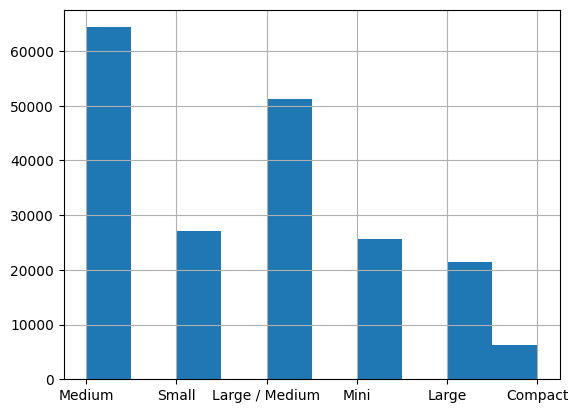

In [9]:
df['ProductSize'].hist();

In [10]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

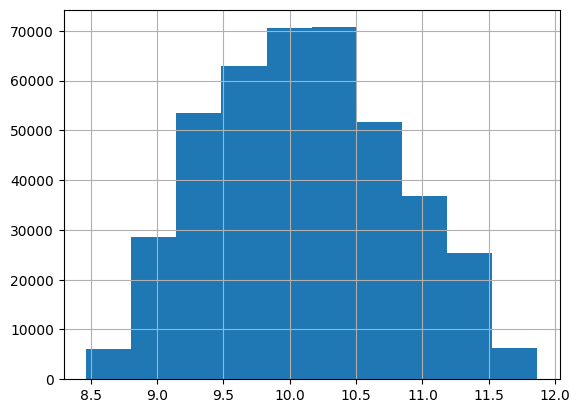

In [11]:
df['SalePrice'].hist();

## Processing Data

In [12]:
# Handling dates using the FastAI tabular library which is super handy imo
# This will add a number of meta data columns by treating dates as ordinal values
# In order words, providing additional categorical variables for the model.
df = add_datepart(df, 'saledate')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  object  
 10  fiBaseModel               412698 non-null  object  
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [13]:
# Doing the same for the test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 1834 non-null   object 
 8   fiModelDesc               12457 non-null  object 
 9   fiBaseModel               12457 non-null  object 
 10  fiSecondaryDesc           8482 non-null   object 
 11  fiModelSeries             2006 non-null   object 
 12  fiModelDescriptor         3024 non-null   object 
 13  ProductSize               6048 non-null   object 
 14  fiProd

In [14]:
# These are all the columns which are dealing with dates
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [15]:
# Using additional FastAI functions, which we can pass in lists
procs = [Categorify, FillMissing]

The date range in the test set covers a six month period from May 2012, which is later in time than dates in the training set.

Our validation set will need to cover data from November 2011 in order to be similar to the test set. Data prior to November 2011 will be part of the training set.

In [16]:
# Creating training and validation splits based on Sales dates and months
cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
# We will create a tuple of lists which will then be passed to TabularPandas
# to identify continuous and categorical columns
splits = (list(train_idx), list(valid_idx))

In [17]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
cont, cat

(['SalesID',
  'MachineID',
  'ModelID',
  'datasource',
  'auctioneerID',
  'YearMade',
  'MachineHoursCurrentMeter',
  'saleYear',
  'saleMonth',
  'saleWeek',
  'saleDay',
  'saleDayofweek',
  'saleDayofyear',
  'saleElapsed'],
 ['UsageBand',
  'fiModelDesc',
  'fiBaseModel',
  'fiSecondaryDesc',
  'fiModelSeries',
  'fiModelDescriptor',
  'ProductSize',
  'fiProductClassDesc',
  'state',
  'ProductGroup',
  'ProductGroupDesc',
  'Drive_System',
  'Enclosure',
  'Forks',
  'Pad_Type',
  'Ride_Control',
  'Stick',
  'Transmission',
  'Turbocharged',
  'Blade_Extension',
  'Blade_Width',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Hydraulics',
  'Pushblock',
  'Ripper',
  'Scarifier',
  'Tip_Control',
  'Tire_Size',
  'Coupler',
  'Coupler_System',
  'Grouser_Tracks',
  'Hydraulics_Flow',
  'Track_Type',
  'Undercarriage_Pad_Width',
  'Stick_Length',
  'Thumb',
  'Pattern_Changer',
  'Grouser_Type',
  'Backhoe_Mounting',
  'Blade_Type',
  'Travel_Controls',
  'Differential_Type',
  

In [18]:
# Tabular Pandas automatically includes train and valid attributes
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)

(404710, 7988)

In [19]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [20]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [21]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'],
                    [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [22]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [23]:
# classes allows us to see the mappings of categorical numberings
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [24]:
to.classes['ProductGroup']

['#na#', 'BL', 'MG', 'SSL', 'TEX', 'TTT', 'WL']

In [25]:
# Saving the file in local pickle format to speed things up.
save_pickle(path/'to.pkl', to)

## Creating a Decision Tree

In [26]:
# Loading our pickle file for speedier processing
to = load_pickle(path/'to.pkl')

In [27]:
# Using previously created indices for our training and validation sets
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
xs.shape, y.shape, valid_xs.shape, valid_y.shape

((404710, 66), (404710,), (7988, 66), (7988,))

In [28]:
# Creating a decision tree
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [29]:
# Visualizing our newly created tree
import graphviz as g

def draw_tree(t, df, size=10, ratio=1.15, precision=2, **kwargs):
  s = g.export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      rounded=True, special_characters=True, rotate=False,
                      precision=precision, **kwargs)
  return g.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

 The draw tree function stopped working all of sudden. I'll need to come back to this.

 Let's see if the `dtreeviz` approach works.

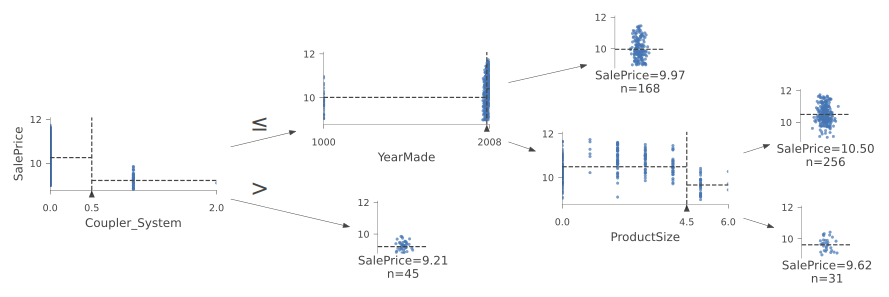

In [30]:
samp_idx = np.random.permutation(len(y))[:500]
# The book's Decision Tree visualizer i.e. dtreeviz() has been deprecated
# Use the following instead
viz_model = dtv.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx],
                      feature_names=xs.columns, target_name=dep_var)
viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

Something is clearly off with our `YearMade` data, where the year 1000 seems to exist for a number of instances. The authors of the book presume that this is a missing value code / placeholder for missing info.

We can replace this with 1950.

In [31]:
xs.loc[xs['YearMade'] < 1950, 'YearMade']= 1950
valid_xs.loc[valid_xs['YearMade'] < 1950, 'YearMade'] = 1950

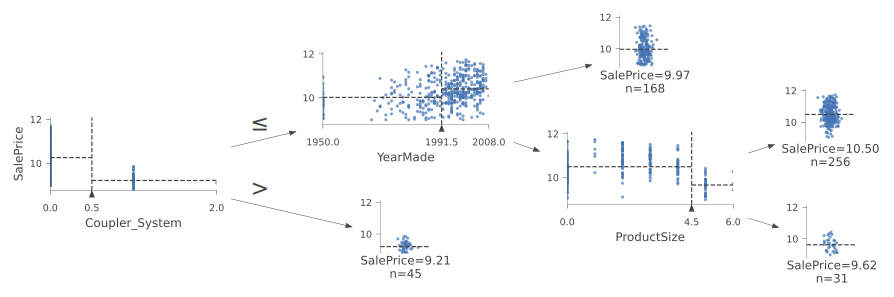

In [32]:
# Retraining the model and replotting
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
# Using the updated dtreeviz code from before
viz_model = dtv.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx],
                      feature_names=xs.columns, target_name=dep_var)
viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

In [33]:
# Creating a bigger decision tree without limiting parameters.
m = DecisionTreeRegressor()
m.fit(xs, y);

In [34]:
# Creating a function to check the RMSE
def r_mse(pred, y):
  return round(math.sqrt(((pred - y)**2).mean()), 6)

def m_rmse(model, xs, y):
  return r_mse(model.predict(xs), y)

In [35]:
m_rmse(m, valid_xs, valid_y)

0.33482

Clearly indicating that we are overfitting.

The number of leaf nodes below is almost equal to the number of data points. This is the direct result of not having implemented a limit to the minimum number of items in each leaf node.

In [36]:
m.get_n_leaves(), len(xs)

(324546, 404710)

In [37]:
# Using sklearn's default setting.
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248616, 0.323309)

In [38]:
m.get_n_leaves()

12397

## Creating a Random Forest

In [39]:
# Creating Random Forest while specifying parameters
# An important note is that max_samples can often be left to its default
# unless we have more than 200,000 data points. In this case, we can set it to
# 200,000 to allow the model to train faster - while having little impact on
# accuracy.
def rf(xs, y, n_estimators=100, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                               max_samples=max_samples,
                               max_features=max_features,
                               min_samples_leaf=min_samples_leaf,
                               oob_score=True).fit(xs, y)

In [40]:
m = rf(xs, y)

In [41]:
# Calculating our validation RMSE
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.169772, 0.231537)

In [42]:
# Assessing the impact of varying n_estimators on the model's performanc by
# getting the predictions from each individual tree in the forest and taking the
# average
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

0.231537

The mean of the predictions from `n_estimators` is the same as the RMSE of the
Random Forest.

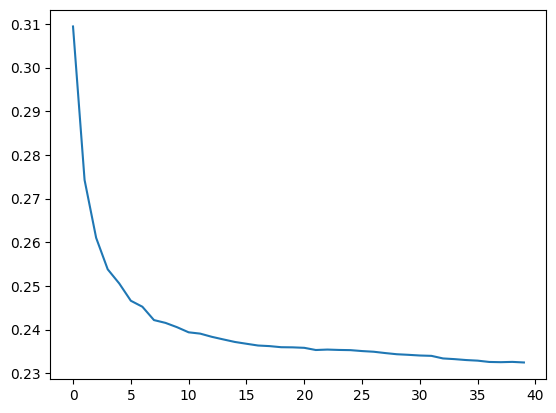

In [43]:
# Plotting the impact of having more predictors on the RMSE
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [44]:
# Calculating OOB prediction error to determine whether or not our model is
# unable to generalize
r_mse(m.oob_prediction_, y)

0.208832

Since the OOB error is lower than the validation set error, it indicates additional factors contributing to the error in addition to the generalization error.

### Model Interpretation and Improvements

In [45]:
# We can use the standard deviation of the predictions across trees to judge the
# relative confidence of predictions. Lower std. deviations show consistency.
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(100, 7988)

In [46]:
# Checking standard deviations for the predictions for the first 10 auctions
preds_std = preds.std(0)
preds_std[:10]

array([0.27887196, 0.14152531, 0.11084929, 0.26552224, 0.12828405,
       0.25321075, 0.30402932, 0.32513246, 0.31378781, 0.180712  ])

The confidence of predictions varies widely. This can be useful in production (low confidence could indicate the need for taking a closer look at independent variables)

### Feature Importance

In [47]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols': df.columns,
                       'imp' : m.feature_importances_,}).sort_values('imp', ascending=False)

In [48]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.177142
30,Coupler_System,0.118478
6,ProductSize,0.116852
7,fiProductClassDesc,0.079606
54,ModelID,0.058588
65,saleElapsed,0.051629
3,fiSecondaryDesc,0.044256
31,Grouser_Tracks,0.033467
1,fiModelDesc,0.032265
32,Hydraulics_Flow,0.031025


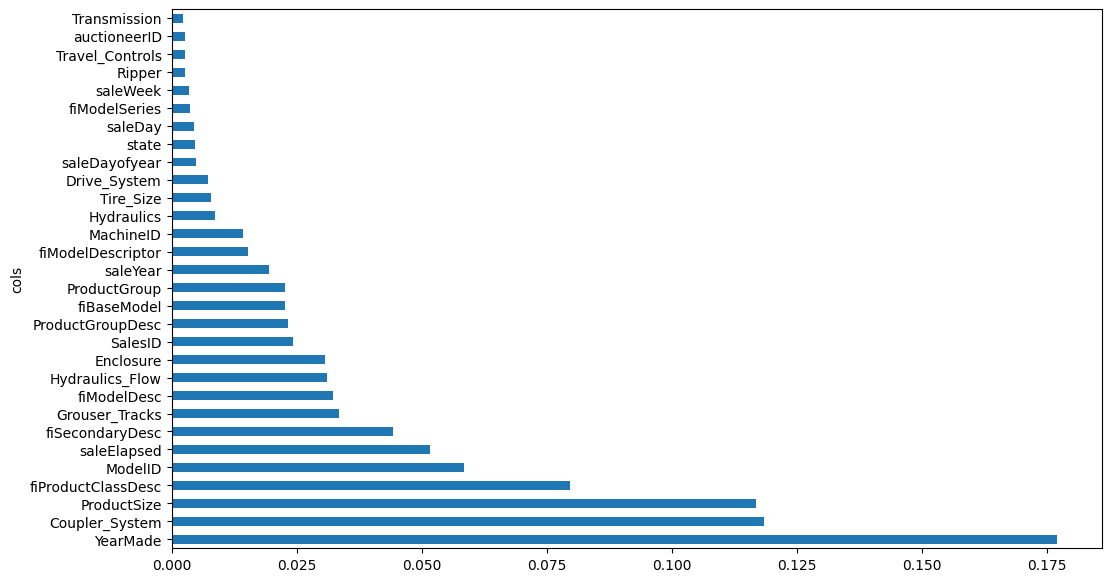

In [49]:
# Plotting FI
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

In [50]:
# We will keep columns above a threshold
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

21

In [51]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

In [52]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.180394, 0.230245)

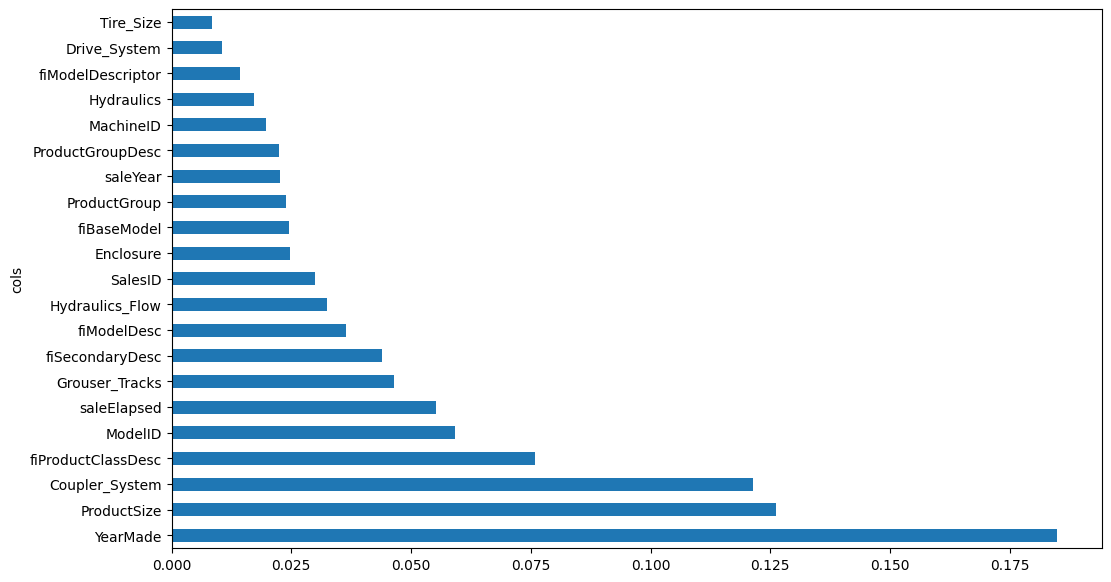

In [53]:
# Plotting fi for the leaner model
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

In [54]:
#  This function can be found in fastbook/utils.py
from scipy.stats import *
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10, 6), font_size=12):
  corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
  corr_condensed = hc.distance.squareform(1-corr)
  z = hc.linkage(corr_condensed, method='average')
  fig = plt.figure(figsize=figsize)
  hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
  plt.show()

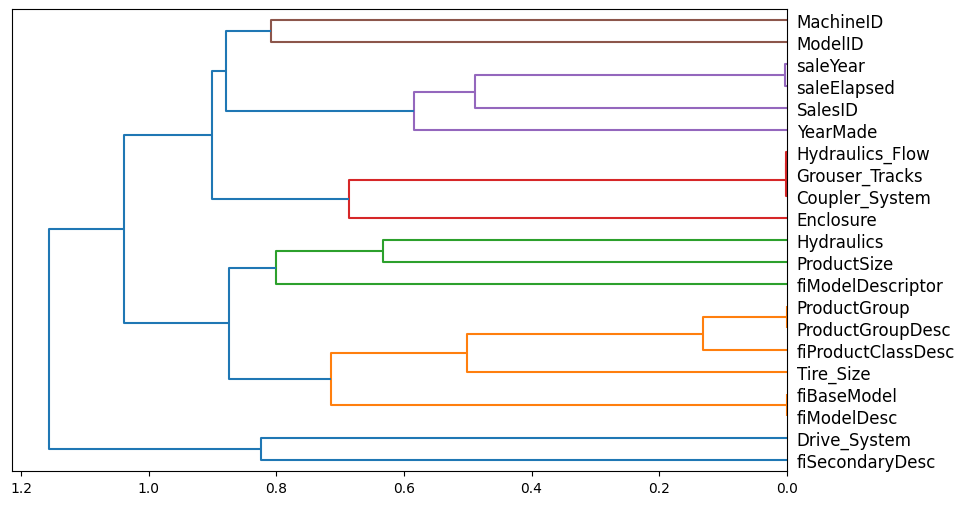

In [55]:
cluster_columns(xs_imp)

Here, we are visualizing the pairs of columns with the highest similarities
(using Spearman ranked correlation), with the root of the trees on the left hand side of the plot.

We can experiment with removing some of these closely related features to determine if the model can be simplified without impacting accuracy.

In [56]:
# Creating a function to train RF and return OOB Scores.
# We will be using lower max_samples and higher min_samples.
def get_oob(df):
  m = RandomForestRegressor(n_estimators=100, min_samples_leaf=15,
                            max_samples=50000, max_features=0.5,
                            n_jobs=-1, oob_score=True)
  m.fit(df, y)
  return m.oob_score_

# This is our baseline
get_oob(xs_imp)

0.8784638852099556

In [57]:
# Experimenting by removing potentially redundant variables
{c: get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc',
    'ProductGroup', 'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System'
)}

{'saleYear': 0.8774165010827759,
 'saleElapsed': 0.873484932355028,
 'ProductGroupDesc': 0.8783584652797826,
 'ProductGroup': 0.8785490758054836,
 'fiModelDesc': 0.8769337057768954,
 'fiBaseModel': 0.8776284493191191,
 'Hydraulics_Flow': 0.8787166045005596,
 'Grouser_Tracks': 0.8781078720982582,
 'Coupler_System': 0.8788678422099803}

In [58]:
# Experimenting with dropping multiple variables from tightly aligned pairs
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8751701285026648

In [59]:
# Creating DFs without the above columns
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [60]:
# Saving pickle file
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [61]:
# Checking RMSE again
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.182357, 0.231132)

### Partial Dependence

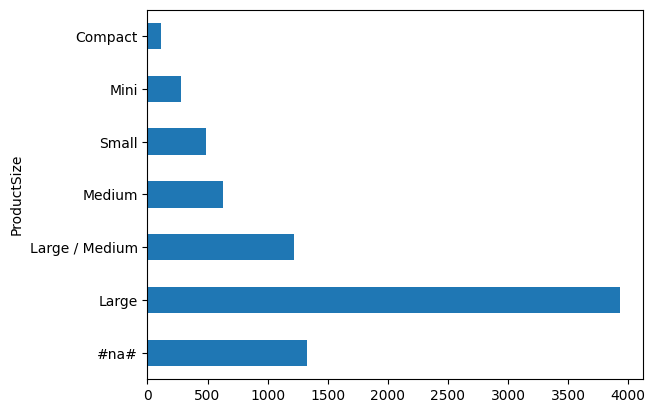

In [62]:
# Lets try to understand the relationship b/w ProductSize, YearMade and
# sale price.
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

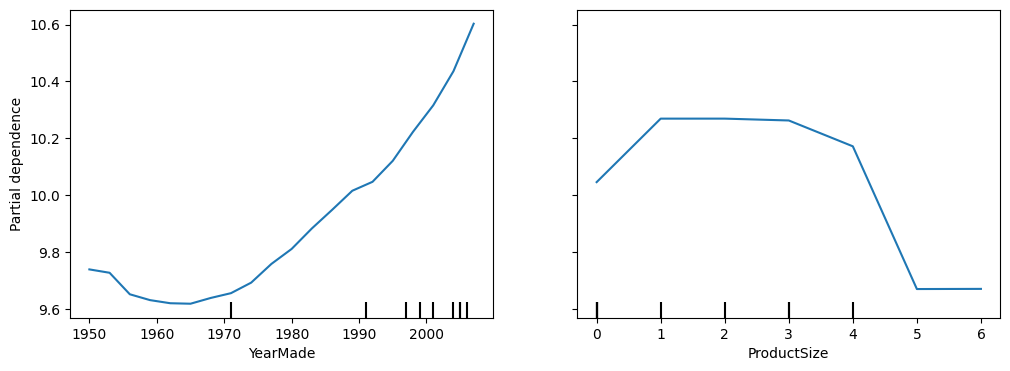

In [63]:
from sklearn.inspection import PartialDependenceDisplay
# The PDP implementation has changed since the book was published.
# This is the updated form
fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade', 'ProductSize'],
                                        grid_resolution=20, ax=ax);

The missing values in `ProductSize` can indicate a potential data leakage problem.

_Leakage_ is defined as:

> The introduction of information about the target of a data mining problem, which should not be legitimately available to mine from. A trivial example of leakage would be a model that uses the target itself as an input, thus concluding for example that 'it rains on rainy days'. In practice, the introduction of this illegitimate information is unintentional, and facilitated by the data collection, aggregation and preparation process.

This is a subtle problem and can take many forms.

Here is the original paper "[Leakage in Data Mining: Formulation, Detection and Avoidance](https://https://dl.acm.org/doi/10.1145/2020408.2020496)"

Some simple heuruistics to identify this issue are:

- Check whether the accuracy of the model is too good to be true.
- Look for important predictors that don't make sense in practice.
- Look for partial dependence plot results that don't make sense in practice.




### Tree Interpreter

The `treeinterpreter` and `waterfallcharts` libraries will be used to determine the influence of the most important factors on predictions based on particular rows of data.

In [64]:
!pip install treeinterpreter

In [65]:
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3388 sha256=c92f10b8f7d9a87dceaf56556727011cec0a94edf2d15d6693fb02b8b40243a9
  Stored in directory: /root/.cache/pip/wheels/bd/34/6c/58fce34a3b8ec5607aff650db14ceb41db8223ac217423371b
Successfully built waterfallcharts


In [66]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [67]:
row = valid_xs_final.iloc[:5]

In [68]:
# Predictions are the outputs of the random forest.
# bias is the prediction based on taking the mean of the dependent variable
# contributions are the total change in prediction due to each of the independent
# variables. So, we have contributions + bias must equal predictions for each row
predictions, bias, contributions = treeinterpreter.predict(m, row.values)

predictions[0], bias[0], contributions[0].sum()

(array([9.99155113]), 10.104634340310767, -0.11308321004014038)

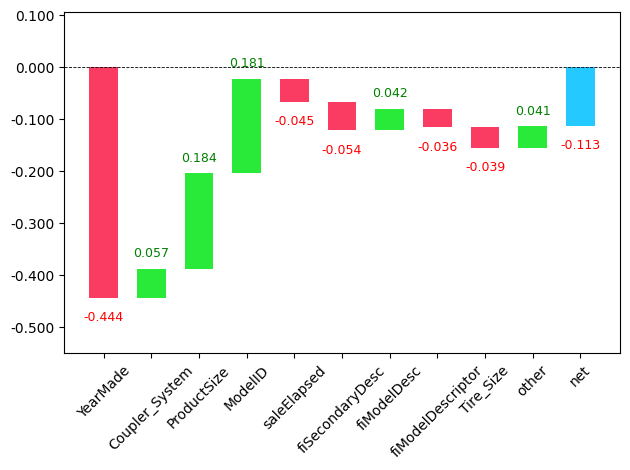

In [69]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45, formatting='{:,.3f}');

### The Extrapolation and Out of Domain Problems

In [70]:
np.random.seed(42)

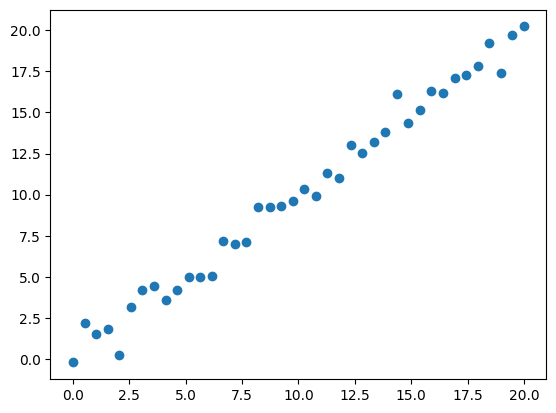

In [71]:
# Consider the case of making predictions from 40 data points
# while showing a slightly noisy linear relationship
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [72]:
# To address sklearn's issue of expecting a matmrix of indep. variables and not
# single vectors, we have to change the shape from [40] to [40, 1]
# Using unsqueeze to add a new unit axis to the tensor.
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [73]:
# We can also slice an array with the special value None to achieve the same
x_lin[:, None].shape

torch.Size([40, 1])

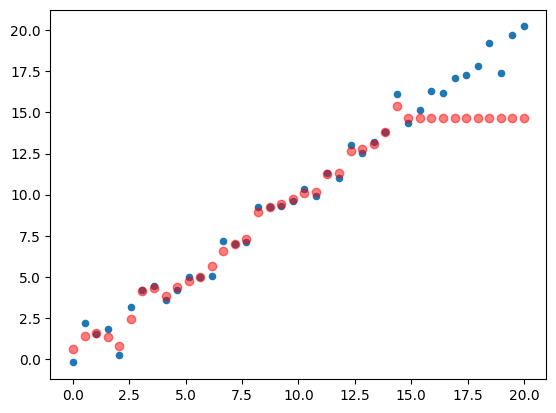

In [74]:
# Creating a random forest on the first 30 rows of the data
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])
# Testing the model on the full data set.
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

This is a case in point that random forests are not able to extrapolate outside the types of data they have been trained on. This brings us to the _Out of Domain_ issue as well.

Random forests can be used to find whether or not our test set is distributed in the same way as our training data. Here we will use the random forest to predict whether a row is in the validation or training set.

In [75]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0] * len(xs_final) + [1] * len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.882687
10,SalesID,0.083858
13,MachineID,0.027666
0,YearMade,0.001579
4,ModelID,0.000894
9,Enclosure,0.000620


Here, 3 columns differ significantly between the training and the validation sets.

In [76]:
# Getting the baseline of the original random forest's RMSE to determine the effect
# of removing these columns.
m = rf(xs_final, y)
print('original', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
  m = rf(xs_final.drop(c, axis=1), y)
  print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

original 0.231387
SalesID 0.229993
saleElapsed 0.233775
MachineID 0.230447


In [77]:
# We can remove SalesID and MachineID without a major impact on accuracy
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228288

In [78]:
# Additionally, old data might not have valid relationships anymore so we can
# train using a more recent dataset.
filt = xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [79]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176809, 0.227964)

## Using a Neural Network

In [80]:
# Loading and pre-processing the data for ingestion by a NN.
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'] = df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

Building on earlier sections, we can trim  all unwanted columns which were also
dropped in the random forest.

In [81]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [82]:
# Given that categorical are handled differently in NNs i.e. they use embeddings.
# A quick note on fastai's handling of embeddings is that the library compares
# the number of distinct levels in potential categorical variables to the
# max_card parameter. Categoricals will have embeddings created if this value is lower
# than max_card. Sizes greater than 10,000 should been reviewed very carefully.

# Proceeding with 9000
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var = dep_var)

In [83]:
cat_nn , cont_nn

(['YearMade',
  'Coupler_System',
  'ProductSize',
  'fiProductClassDesc',
  'ModelID',
  'fiSecondaryDesc',
  'fiModelDesc',
  'Hydraulics_Flow',
  'Enclosure',
  'ProductGroup',
  'fiModelDescriptor',
  'Hydraulics',
  'Tire_Size',
  'Drive_System'],
 ['saleElapsed'])

In [84]:
# Cardinality of each categorical variable
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Hydraulics_Flow          3
Enclosure                6
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

`NOTE` In the case of extremely high cardinality columns - we must remember that each level will need a column in the embedding matrix so 5000 levels = 5000 embedding columns. Needless to say, this should be avoided where possible.

In [85]:
# Testing the impact of removing high cardinality columns on the random forest
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176018, 0.229193)

In [86]:
# Removing due to low impact
cat_nn.remove('fiModelDescriptor')

In [87]:
# Creating TabularPandas object with the additional of Normalization which contrasts
# with the random forest / decision tree approach. Neural Nets are very sensitive to scale
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                       splits=splits, y_names=dep_var)

In [88]:
# Tabular models are GPU memory intensive, so we can use larger batche sizes
dls = to_nn.dataloaders(1024)

In [88]:
# Finding the min and max of the dependent variabel to set y_range for regression
y = to_nn.train.y
y.min(), y.max()

In [89]:
# Creating the learner with defaults of two hidden layers with 500 and 250
# activations due to the size of the dataset
learn = tabular_learner(dls, y_range=(8, 12), layers=[500, 500],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00010964782268274575)

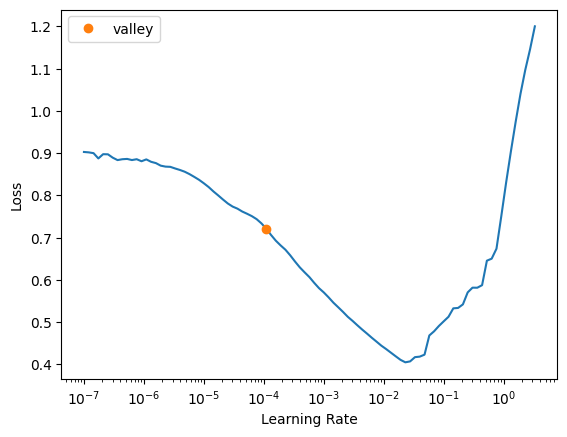

In [90]:
learn.lr_find()

In [91]:
# Since we are not fine tuning, we'll train with fit_one_cycle for a few epochs
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.073337,0.128665,00:05
1,0.068970,0.070518,00:04
2,0.055508,0.055909,00:05
3,0.044521,0.052205,00:05
4,0.042333,0.052055,00:04


In [93]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.228156

In [94]:
learn.save('nn')

Path('models/nn.pth')